In [2]:
import sys
sys.path.append("../../")
from simulation_classes.flying_cars import FlyingCars
from simulation_classes.simulation_periodic import SimulationPeriodic
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
"""
シミュレーションの基本的な設定
基本的には ./periodic_simulation.ipynbを参考にしている。
DRONE_NUMについてfor文を回すためのファイル
"""

TOTAL_TIME = 100
time_step = 0.2
simulation_steps = int(TOTAL_TIME / time_step)
scale_factor = 20
legal_speed = 1.5
real_legal_speed = min(2, legal_speed) * scale_factor * 3.6
TOTAL_DISTANCE = 100
boundary_condition = "PERIODIC"
UPDATE_RULE = "parallel"
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 5 # 0.5Gくらい

# 先頭の車が前になるように置く(一番後ろの車はx=0でスタート)
def scatter_cars_around(total_distance, car_num, idx, should_scatter=False):
    delta = total_distance / car_num
    return total_distance - delta * (idx+1)

In [4]:
result_obj = {}

min_headway = 10 # 一番密度が高い時の車間距離を [m] で設定
drone_num_for_max_density = int(TOTAL_DISTANCE * scale_factor / min_headway) #その時のドローン台数
print(f"最大ドローン台数：{drone_num_for_max_density}台")
increment = 5

最大ドローン台数：200台


### ここからシミュレーション開始。

In [5]:
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor

helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.482,
    "T_des": 1,
    "isRss":False
  }

simulation_list = []

for i in range(int(drone_num_for_max_density / increment)):
    DRONE_NUM = (i+1) * increment
    if (DRONE_NUM >206):
        break
    cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                     ycor=0, 
                     v_0=0,
                     legal_speed=legal_speed, 
                     scale_factor=scale_factor,
                     drone_idx = i,
                     helly_params=helly_params,
                     )
               for i in range(DRONE_NUM)]
    print(DRONE_NUM)
    simulation = SimulationPeriodic(
        TOTAL_TIME=TOTAL_TIME, 
        time_step=time_step, 
        scale_factor=scale_factor,
        drone_list=cars_list,
        TOTAL_DISTANCE=TOTAL_DISTANCE,
        UPDATE_RULE=UPDATE_RULE )
    simulation.run()
    simulation_list.append(simulation)

    

5
===PARALLEL実行===
FINISHED
10
===PARALLEL実行===
FINISHED
15
===PARALLEL実行===
FINISHED
20
===PARALLEL実行===
FINISHED
25
===PARALLEL実行===
FINISHED
30
===PARALLEL実行===
FINISHED
35
===PARALLEL実行===
FINISHED
40
===PARALLEL実行===
FINISHED
45
===PARALLEL実行===
FINISHED
50
===PARALLEL実行===
FINISHED
55
===PARALLEL実行===
FINISHED
60
===PARALLEL実行===
FINISHED
65
===PARALLEL実行===
FINISHED
70
===PARALLEL実行===
FINISHED
75
===PARALLEL実行===
FINISHED
80
===PARALLEL実行===
FINISHED
85
===PARALLEL実行===
FINISHED
90
===PARALLEL実行===
FINISHED
95
===PARALLEL実行===
FINISHED
100
===PARALLEL実行===
FINISHED
105
===PARALLEL実行===
FINISHED
110
===PARALLEL実行===
FINISHED
115
===PARALLEL実行===
FINISHED
120
===PARALLEL実行===
FINISHED
125
===PARALLEL実行===
FINISHED
130
===PARALLEL実行===
FINISHED
135
===PARALLEL実行===
FINISHED
140
===PARALLEL実行===
FINISHED
145
===PARALLEL実行===
FINISHED
150
===PARALLEL実行===
FINISHED
155
===PARALLEL実行===
FINISHED
160
===PARALLEL実行===
FINISHED
165
===PARALLEL実行===
FINISHED
170
===PARALLEL実行===
FINISHED


In [ ]:
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor

helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.482,
    "T_des": 1,
    "isRss":False
  }

simulation_list = []

for i in range(int(drone_num_for_max_density / increment)):
    DRONE_NUM = (i+1) * increment
    if (DRONE_NUM >206):
        break
    cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                     ycor=0, 
                     v_0=0,
                     legal_speed=legal_speed, 
                     scale_factor=scale_factor,
                     drone_idx = i,
                     helly_params=helly_params,
                     )
               for i in range(DRONE_NUM)]
    print(DRONE_NUM)
    simulation = SimulationPeriodic(
        TOTAL_TIME=TOTAL_TIME, 
        time_step=time_step, 
        scale_factor=scale_factor,
        drone_list=cars_list,
        TOTAL_DISTANCE=TOTAL_DISTANCE,
        UPDATE_RULE=UPDATE_RULE )
    simulation.run()
    simulation_list.append(simulation)

    

### ここからは解析に入る

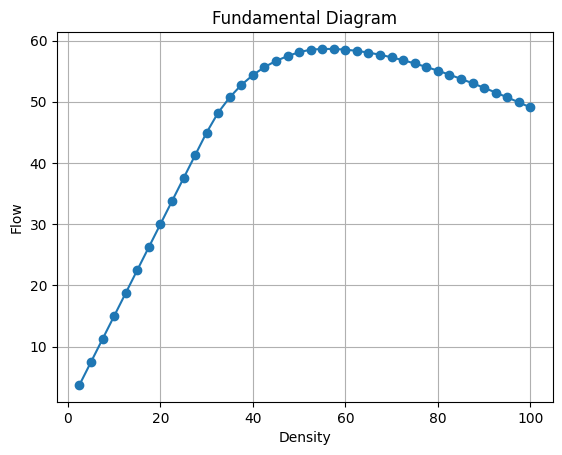

In [13]:
import pandas as pd

dataList = []
for simulation in simulation_list:
    cars = simulation.drone_list
    # 流量を計算する
    velocity_list = []
    for car in cars:
        snap_frame = int(simulation_steps * 0.95)
        velocity_list.append(car.v_xList[snap_frame])
    mean_velocity = np.mean(np.array(velocity_list))

    # 密度：1km当たりの台数
    rho = len(cars) / (TOTAL_DISTANCE * scale_factor)  * 1000
    flow = rho * mean_velocity

    # プロット用に保存
    dataToSave = {
        "density":rho,
        "flow":flow,
        "mean_velocity":mean_velocity,
        "start_position":"unscattered",
        "drone_num":len(cars),
        "model":"Helly"
    }
    dataList.append(dataToSave)

df = pd.DataFrame(dataList)
df.head()

# 折れ線グラフを描画
plt.plot(df["density"], df["flow"], marker='o')
plt.xlabel('Density')
plt.ylabel('Flow')
plt.title('Fundamental Diagram')
plt.grid(True)
plt.show()


In [14]:
# ここからdebug開始 
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor

helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.5,
    "T_des": 1,
    "isRss": True,
  }

DRONE_NUM = 180
    
cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                ycor=0, 
                v_0=0,
                legal_speed=legal_speed, 
                scale_factor=scale_factor,
                drone_idx = i,
                helly_params=helly_params,
                )
          for i in range(DRONE_NUM)]
print(DRONE_NUM)
simulation = SimulationPeriodic(
  TOTAL_TIME=TOTAL_TIME, 
  time_step=time_step, 
  scale_factor=scale_factor,
  drone_list=cars_list,
  TOTAL_DISTANCE=TOTAL_DISTANCE,
  UPDATE_RULE=UPDATE_RULE )
simulation.run()

drones = simulation.drone_list
drone_1 = drones[2]
print(drones[1].xcorList[400:])

180
===PARALLEL実行===
FINISHED
[2.8845886398620593, 2.8954615959368795, 2.9063345537876017, 2.917207513361433, 2.928080474607185, 2.9389534374751634, 2.9498264019171785, 2.9606993678864484, 2.971572335337612, 2.98244530422663, 2.9933182745107985, 3.004191246148679, 3.0150642191000685, 3.0259371933259445, 3.036810168788449, 3.0476831454508755, 3.058556123277583, 3.069429102233997, 3.080302082286579, 3.0911750634027726, 3.102048045551001, 3.112921028700626, 3.123794012821932, 3.1346669978860575, 3.1455399838650067, 3.156412970731637, 3.167285958459587, 3.1781589470232916, 3.189031936397953, 3.1999049265594834, 3.210777917484535, 3.2216509091504406, 3.2325239015352025, 3.24339689461749, 3.254269888376598, 3.265142882792432, 3.276015877845495, 3.2868888735168724, 3.297761869788218, 3.308634866641711, 3.3195078640600713, 3.33038086202653, 3.341253860524816, 3.3521268595391405, 3.3629998590541845, 3.3738728590550693, 3.384745859527385, 3.3956188604571196, 3.406491861830702, 3.4173648636349583